Server (or Remote) notebook used to measure the throughput and latency of the retina pipeline vs the standard pipeline.

This notebook receives the compressed retinal vectors and frames from the benchmark_client notebook.

In [1]:
#Standard imports
import numpy as np
from matplotlib import pyplot as plt
import cv2
import pickle
import time
import zlib
import zmq

In [2]:
#Measure latency. n refers to the number of messages to be received
def measure_latency(n=100):
    #Connect to the client
    context = zmq.Context()
    socket = context.socket(zmq.PULL)
    socket.bind("tcp://*:5555")
    
    #Save the times at which the messages were received
    end_times=[]
    for i in range(0, n):
        socket.recv()
        end_times.append(time.time())
    #Get the Client side start times
    start_times = eval(socket.recv())
    print("Done")
    return np.asarray(end_times)-np.asarray(start_times)

#Measure the throughput
def measure_throughput():
    #Connect to the Client
    context = zmq.Context()
    socket = context.socket(zmq.PULL)
    socket.bind("tcp://*:5555")
    
    #Store the message sizes
    size=[]
    #Number of messages to be received
    n = int(socket.recv())
    
    #Start timer and see how long it takes to receive the messages
    start = time.time()
    for i in range(0,n):
        data = socket.recv()
        size.append(len(data))
    end = time.time()
    #Return the messages sizes and the time taken to send them
    return (size, end-start)
    

# THROUGHPUT

In [4]:
### Measure the retinal pipeline throughput over 100 runs
retinal_throughputs = []
for i in range(0, 100):
    #Get messages sizes and time taken to send them
    sizes, duration = measure_throughput()
    #Divide average size by time taken to get throughput
    retinal_throughputs.append(100 * np.mean(sizes)/duration)
print('Mean Throughput: ', np.mean(retinal_throughputs))

Mean Throughput:  18108111836.527355


In [3]:
### Measure the standard pipeline throughput over 100 runs
frame_throughputs = []
#Does the same as the retinal pipleine
for i in range(0, 100):
    sizes, duration = measure_throughput()
    frame_throughputs.append(100 * np.mean(sizes)/duration)
print('Mean Throughput: ', np.mean(frame_throughputs))

Mean Throughput:  16111858289.329155


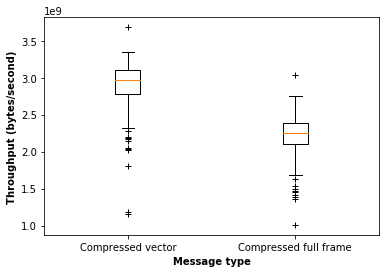

In [31]:
#Plot the throughputs
throughputs = [retinal_throughputs, frame_throughputs]
plt.boxplot(throughputs, sym='+')
plt.xticks([1,2], ['Compressed vector', 'Compressed full frame'])
plt.xlabel('Message type', fontweight='bold')
plt.ylabel('Throughput (bytes/second)', fontweight='bold')

#plt.savefig('throughput.eps')

# Latency

In [28]:
### Measure latency for the retina pipeline
retinal_latency = measure_latency(100)
print('Mean latency: ', np.mean(retinal_latency))

Done
Mean latency:  0.007730817794799805


In [23]:
### Measure latency for the standard pipeline
frame_latency = measure_latency(100)
print('Mean latency: ', np.mean(frame_latency))

Done
Mean latency:  0.019606451988220214


In [26]:
### Measure latency for an arbitrary 64 byte message
arbitrary = measure_latency(10000)
print('Mean latency: ', np.mean(abitrary))

Done
Mean latency:  0.0014734190940856933


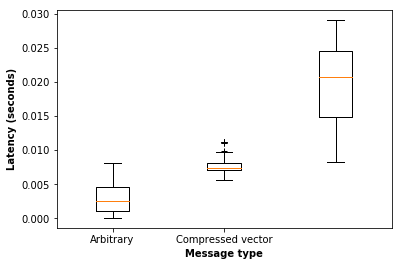

In [30]:
#Plot latencies
throughputs = [arbitrary, retinal_latency, frame_latency]
plt.boxplot(throughputs, sym='+')
plt.xticks([1,2], ['Arbitrary', 'Compressed vector', 'Compressed full frame'])
plt.xlabel('Message type', fontweight='bold')
plt.ylabel('Latency (seconds)', fontweight='bold')

#plt.savefig('latency_with_arbitrary.eps')